table deleted


<IPython.core.display.Javascript object>


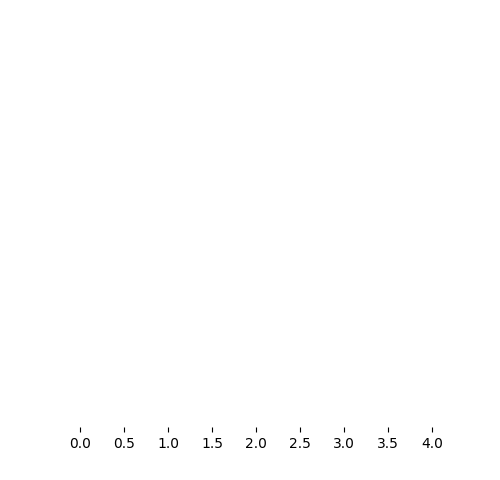

No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
heat Capacity in kWh is:  3.351798855418726e-05
Load in kWh is: 6.143664766908518e-05
df whole is:     id            dateTime     Tamb  TtopTestTankHPCir  TbottomTestTankHpCir  \
0  760 2021-01-29 08:13:46  21.5079            36.3071               25.2608   

   TtopSourceTank  TloadTankMix  TTopTestTankLoadCir  TloadMix  \
0         20.7308       23.4683              36.5107   22.0824   

   TbottomSourceTank  ...       T2       T3       T4       T5       T6  \
0             18.198  ...  28.2052  26.8172  25.7006  37.3594  37.3594   

        T7       T8       T9   flowHP  flowLoad  
0  36.7823  35.3908  33.6608  1.89827  2.901221  

[1 rows x 23 columns]
Load in kWh is: 6.143664766908518e-05
heat Capacity in kWh is:  3.351798855418726e-05
________________________________________________________________
flow rates load is =  0.6

df whole is:     id            dateTime     Tamb  TtopTestTankHPCir  TbottomTestTankHpCir  \
0  760 2021-01-29 08:13:46  21.5079            36.3071               25.2608   
1  761 2021-01-29 08:13:47  21.5079            36.3071               25.2946   
2  762 2021-01-29 08:13:49  21.5417            36.3410               25.2946   
3  763 2021-01-29 08:13:51  21.5417            36.3410               25.2608   

   TtopSourceTank  TloadTankMix  TTopTestTankLoadCir  TloadMix  \
0         20.7308       23.4683              36.5107   22.0824   
1         20.7308       23.4345              36.4768   22.0824   
2         20.7308       23.4345              36.5107   22.1162   
3         20.7308       23.4345              36.5107   22.0824   

   TbottomSourceTank  ...       T2       T3       T4       T5       T6  \
0            18.1980  ...  28.2052  26.8172  25.7006  37.3594  37.3594   
1            18.1642  ...  28.2052  26.7834  25.7006  37.3594  37.3254   
2            18.1980  ...  28.171

KeyboardInterrupt: 

In [1]:
import time
import board
import busio
import pandas as pd
from pandas import DataFrame
from matplotlib import pylab
import matplotlib.pyplot as plt
from pylab import *
import pylab
import numpy as np
import matplotlib.colors as clrs
import matplotlib.cm as cm
import matplotlib
from collections import deque
#matplotlib.use('TkAgg')
%matplotlib notebook
#%matplotlib inline

#import time
import sys
import sqlite3
#from time import sleep

#import adafruit_ads1x15.ads1015 as ADS
import adafruit_ads1x15.ads1115 as ADS
from adafruit_ads1x15.analog_in import AnalogIn

import MySQLdb as db

HOST = "10.208.8.122"
PORT = 3306
USER = "yogi"
PASSWORD = "bittoo"
DB = "TemaccessToRemoteRp2"
'''
try:
    connection = db.Connection(host=HOST, port=PORT,
                               user=USER, passwd=PASSWORD, db=DB)

    c = connection.cursor()
    c.execute("SELECT * from temSensor")
    result = c.fetchall()
    for item in result:
        print (item)

except Exception as e:
    print (e)
'''
connectionL = db.connect(host="10.208.8.121",
                     user="yogi",
                     passwd="bittoo",
                     db="allSensors")

#c = conn.cursor()
connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)

cR = connectionR.cursor()
cL =connectionL.cursor()

i2c = busio.I2C(board.SCL, board.SDA)

# Create the ADC object using the I2C bus
ads = ADS.ADS1115(i2c)

ads.gain = 1


cL.execute('DROP TABLE IF EXISTS flowReadings;')
print ('table deleted')


cL.execute('CREATE TABLE flowReadings(id INT AUTO_INCREMENT PRIMARY KEY, ts TIMESTAMP DEFAULT CURRENT_TIMESTAMP, flowHP FLOAT, flowLoad FLOAT);')


#cvsFileName = import os.path
#os.path.exists(file_path)

lol=[[], [], []]
flowRateLoad  = []

def flatten(l_of_l):
    T = l_of_l[0]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l

def mct(Lol):
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    #this is density as polynomial function of T
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]

    #pV = [(999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5)*2.7777e-07*y for x, y in zip(T, mHP)  ]
    # this is mass flow  in kg/S =  density*V(flow rate in m^3/sec)= d * (1000^-3/3600)
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    #this is Cp as functiono of T linear function
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    #mCT1 = sum([(4.253264761904763 - 0.00470305*b[2])*a*(b[2]-b[3]) for a, b in zip(mHP, T)])
    #mCT_kW = [(4.253264761904763 - 0.00470305*b[2])*a*(b[3]-b[4]) for a, b in zip(mHP, T)]
    #Cp*M*deltaT
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    # sum(mct* 5/3600 (time stamp))  = kWh
    mCT2_kWh = sum([m*c*(dt[3]-dt[4])*0.0013888889 for m, c, dt in zip(mF_kgPerS,  cP_kjPerkgK, T)])
    print ('heat Capacity in kWh is: ', mCT2_kWh)
    
    #print (T[-1], mHP,'mCpDeltaT =', mCT)
    #print ('mCT is:',mCT)
    #print ('mF', mF_kgPerS, mHP[-1])
    #print (' mCT_kW is:', mCT_kW)
    #print ('mCTkWh is ',mCT2_kWh)
    return mCT_kW

l_id = []

def idGenerator(Id, l_id):
    if Id not in l_id:
       l_id.append(Id) 
    #print (l_id)
    return l_id

#df_conc= None
def dfs(Lol):
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    StartTemTestingtank = [ 'id', 'dateTime', 'Tamb', 'TtopTestTankHPCir', 'TbottomTestTankHpCir', 'TtopSourceTank', \
'TloadTankMix','TTopTestTankLoadCir', 'TloadMix', 'TbottomSourceTank', 'TbottomTestTankLoadCir']
    l_T = ['T{}'.format(x) for x in range(0,10)]
    L = StartTemTestingtank +l_T
    df_mHP = DataFrame(mHP, columns=['flowHP'])
    df_mL = DataFrame(mL, columns=['flowLoad'])
    df_tem = DataFrame(T, columns = L)
    df_conc = pd.concat([df_tem, df_mHP, df_mL], axis=1)
    
    #print (df_mL)
    #print (df_mHP)
    #print (df_tem)
    #print (df_conc)
    return df_conc

def list2df(lis, column_name = None):
    df  = pd.DataFrame(lis, columns = [column_name]) 
    return df
    
def toCsv(df_full, load_kW, heatCapacity_kW):
    df_Tem_Flow_Load_capacity_conc = pd.concat([df_full, load_kW, heatCapacity_kW], axis=1)
    import os.path
    import datetime
    file_name = 'csvFile_{}'.format(datetime.datetime.now().strftime("%Y_%m_%d"))
    suffix = '.csv'
    filePath = os.path.join(os.getcwd(), file_name + suffix)
    df_Tem_Flow_Load_capacity_conc.to_csv(filePath, header=True)
    return df_Tem_Flow_Load_capacity_conc

def Load_kWh(Lol):
    
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    #this is density as polynomial function of T
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[10] - 8.42930922e-03*x[10]**2 + 6.77190849e-05*x[10]**3 \
 - 4.40840180e-07*x[10]**4 + 1.29302849e-09*x[10]**5 for x in T]
    #print ('denisty is:', p_LperH )
    #print ('Tem is:', [x[10] for x in T])
    # this is mass flow  in kg/S =  density*V(flow rate in m^3/sec)= d * (1000^-3/3600)
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mL)]
    #this is Cp as functiono of T linear function
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[10] for b in T]
    #print ('Cp is:', cP_kjPerkgK)
    #Cp*M*deltaT
    mCT_kW = [c*a*(b[7]-b[10]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT2_kWh = sum([m*c*(dt[7]-dt[10])*0.0013888889 for m, c, dt in zip(mF_kgPerS,  cP_kjPerkgK, T)])
    print ('Load in kWh is:', mCT2_kWh)
    return mCT_kW
    
def tankStrat(df):
    dfT = df.iloc[:, 11:-2]
    #print (dfT.columns)
    #print (dfT)
    dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T9', 'T8', 'T7', 'T6', 'T5']]
    dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T9':'T5', 'T8':'T6',\
              'T7':'T7','T6':'T8','T5':'T9'}, axis='columns')
    #dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T5', 'T6', 'T7', 'T8', 'T9']]
    #dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T8', 'T9', 'T5', 'T6', 'T7']]
    #dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T8':'T5', 'T9':'T6',\
    #           'T5':'T7','T6':'T8','T7':'T9'}, axis='columns')
    #dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T5':'T5', 'T6':'T6',\
    #          'T7':'T7','T8':'T8','T9':'T9'}, axis='columns')
    #dfT.columns = ['T4', 'T3', 'T2', 'T1', 'T0', 'T5', 'T6', 'T7', 'T8', 'T9']
    #print (dfT)
    return dfT
#tankStratTem = tankStrat(df_conc)


    
def create_color_step_obj(cmap_name, n):
    """
    Return scalarMap object with n colors in gradient from color map
    given in cmap_name.
    """
    cmap = plt.get_cmap(cmap_name)
    values = range(n)
    cNorm  = clrs.Normalize(vmin=values[0], vmax=values[-1])
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    return scalarMap

#import logging
#logging.getLogger().setLevel(logging.CRITICAL)

# colors
cmap_name = "jet"
scm = create_color_step_obj(cmap_name, 10)


def plotObject(df, ax, fig, alpha =0.7, scm=None):
    ax.clear()
    for i in range (0, df.shape[1]):
        ax.plot(df.index, df.iloc[:, i], color= scm.to_rgba(i, alpha=alpha),\
                label = 'Layer ' + str(i))
        ax.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax.legend()
    #plt.legend(loc='upper left')
    return fig, ax
    
# initialize figure and interactivity
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.legend(loc='best')
ax.set_xlabel('Index')
ax.set_ylabel('Tem, C', color='r')


'''
def plotObject(df, ax1,  fig, alpha =0.7, scm=None):
    #ax2.clear()
    ax1.clear()
    for i in range (0, df.shape[1]):
        ax1.plot(df.index, df.iloc[:, i], color= scm.to_rgba(i, alpha=alpha),\
                label = 'Layer ' + str(i+1))
        ax1.legend(bbox_to_anchor=(0.4,0.8))
    
    #ax2.plot(dfFlowtem.index, dfFlowtem.iloc[:, 1])
    #ax3.plot(dfFlowtem.index, dfFlowtem.iloc[:, 2])
    
    fig.canvas.draw()
    #ax2.legend()
    #ax3.legend()
    #legend_without_duplicate_labels(ax2)
    #plt.legend(loc='upper left')
    return fig, ax1, ax2, ax3


# initialize figure and interactivity
#fig = plt.figure()
fig, ax1 = plt.subplots(1)
plt.ion()

fig.show()
fig.canvas.draw()
ax1.legend(loc='best')
ax1.set_xlabel('Index')
ax1.set_ylabel('Tem, C', color='r')


ax2.legend(loc='best')
ax2.set_xlabel('Index')
ax2.set_ylabel('Tank outlet, C', color='r')


ax3.legend(loc='best')
ax3.set_xlabel('Index')
ax3.set_ylabel('TankInletTem, C', color='r')
'''

#plt.legend(loc='best')


while True:
    #c.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(?,?,?,?)", (chan2.voltage, chan1.voltage))
    #connection.commit()
    chan1 = AnalogIn(ads, ADS.P0)
    chan2 = AnalogIn(ads, ADS.P1)

    chan1Vol = chan1.voltage
    chan1curr = chan1Vol/159.42

    chan2Vol = chan2.voltage
    chan2curr=chan2Vol/159.65
    #flow1 = ((chan1Vol/159.42)*1000 -4)/16*1000
    flow1 = ((chan1Vol/159.42)-0.003956)/0.0000159
    #flow2 = ((chan2Vol/159.65)*1000 -4)/16*4000 +20
    #flow2 = ((chan2Vol/159.65)- 0.0005468893873066417)/1.09561608e-05
    flow2 = ((chan2Vol/159.65)- 0.003973767754877122)/5.3038815e-06
    cL.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(%s, %s)", (flow2, flow1))
    connectionL.commit()
    #print('flow HP:',"{:>5}\t{:>5.3f}".format(chan2.value, chan2.voltage), '\n\n')
    #print('flow load:',"{:>5}\t{:>5.3f}".format(chan1.value, chan1.voltage, '\n\n'))
    print('flow rates load is = ',chan1Vol, chan1curr,flow1 )
    print('flow rates HP is = ',chan2Vol, chan2curr,flow2 )

    connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)
    cR = connectionR.cursor()
    #c.execute("SELECT * from temSensor")
    cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    result = cR.fetchall()
    #print ('result is',result)
    id = result[0][0]
    idGenerator(id, l_id)
    #print ('id is :', id)
    flowRateLoad.append(flow1)

    if lol[0] ==[] or id < lol[0][-1][0][0] :
        lol[0].append(result)
        #print (lol)
        lol[1].append(flow1)
        lol[2].append(flow2)
    elif lol[0] != [] and id > lol[0][-1][0][0]:

        lol[0].append(result)
        lol[1].append(flow1)
        lol[2].append(flow2)


    mct(lol)
    Load = Load_kWh(lol)
    #print ('load in kWh is:', Load)
    #print ('lol is:',lol)
    #print ('df of tem is:',df_tem)
    #print ('df is:', tankStrat(dfs(lol)))
    df = tankStrat(dfs(lol))
    #restTem = InletTem(dfs(lol))
    #print (df)
    fig, ax = plotObject(df, ax,  fig, alpha=0.7, scm=scm)
    print ('df whole is:', dfs(lol))
    toCsv(dfs(lol), list2df(Load_kWh(lol), 'Load_kW'), list2df(mct(lol),'Heat_Capacity_kW'))
    #print ('df is:', df)
    #plot(tankStrat(dfs(lol)), plotObject(tankStrat(dfs(lol))))
    #plotObject(tankStrat(dfs(lol)))for i in range (0, 10):
    #x = tankStrat(dfs(lol)).index[-1]
    #y =tankStrat(dfs(lol)).iloc[-1]
    #print ('x is:',x,'y is :',y)
    #restTem = InletTem(dfs(lol))
    #print ('rets of inlet tem values are:', restTem.iloc[:, 1])
    print('________________________________________________________________')
    time.sleep(0.05)

In [11]:
1+1

2